In [1]:
import albumentations as albu
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils

from torch import from_numpy, load
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

## Test best saved model

In [2]:
# load best saved checkpoint
best_model = load(r"models\U-Net(scse)_mit-b2(frozen)_imagenet\U-Net(scse)_mit-b2(frozen)_imagenet.pth")

In [3]:
class Dataset(BaseDataset):
    """Udder Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. normalization, shape manipulation, etc.)

    """

    CLASSES = ["unlabelled", "udder"]
    CLASS_VALUES = [0, 255]

    def __init__(
        self,
        images_dir,
        masks_dir,
        classes=None,
        augmentation=None,
        preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [
            os.path.join(masks_dir, os.path.splitext(image_id)[0] + ".png")
            for image_id in self.ids
        ]

        # convert str names to class values on masks
        self.class_values = [
            self.CLASS_VALUES[self.CLASSES.index(cls.lower())] for cls in classes
        ]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.ids)

In [4]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(
            min_height=480, min_width=640, border_mode=1, always_apply=True
        )
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [5]:
ENCODER = "mit_b3"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ["udder"]
DEVICE = "cuda"

In [6]:
x_test_dir = "data\images\\test"
y_test_dir = "data\masks\\test"

In [7]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

Accuracy according to IoU threshold

In [8]:
from torch import sum
from segmentation_models_pytorch.utils import base

loss = smp_utils.losses.DiceLoss()

class Accuracy(base.Metric):
    """
    Accuracy for identification according to iou_threshold
    Returns a tensor of 1s and 0s according to correctness of identification
    """
    def __init__(self, eps=1e-7, iou_threshold=0.5, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.iou_threshold = iou_threshold

    def forward(self, pr, gt):
        intersection = sum(gt * pr)
        union = sum(gt) + sum(pr) - intersection + self.eps
        iou_scores =  (intersection + self.eps) / union
        return (iou_scores > iou_threshold)


start_threshold = 0.5
end_threshold = 1.0
step = 0.05

iou_results = dict()
for iou_threshold in np.arange(start_threshold, end_threshold, step):
    metrics = [
        Accuracy(iou_threshold=iou_threshold)
    ]

    # evaluate model on test set
    test_epoch = smp_utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )

    logs = test_epoch.run(test_dataloader)
    iou_results[iou_threshold] = logs

valid: 100%|██████████| 431/431 [00:17<00:00, 24.85it/s, dice_loss - 0.09663, accuracy - 0.0]


In [9]:
iou_thresholds = list(iou_results.keys())
accuracies = [data["accuracy"] for data in iou_results.values()]

In [10]:
def select_ticks(ticks, sorting = 'descending', threshold=0.02):
    assert sorting in ['ascending', 'descending']
    if sorting == 'ascending':
        sorted_ticks = sorted(ticks)
        selected_ticks = [sorted_ticks[0]]
        for sorted_tick in sorted_ticks[1:]:
            if sorted_tick - selected_ticks[-1]  > threshold:
                selected_ticks.append(sorted_tick)
    else: # sorting == 'descending'
        sorted_ticks = sorted(ticks, reverse=True)
        selected_ticks = [sorted_ticks[0]]
        for sorted_tick in sorted_ticks[1:]:
            if selected_ticks[-1] - sorted_tick > threshold:
                selected_ticks.append(sorted_tick)
    return selected_ticks

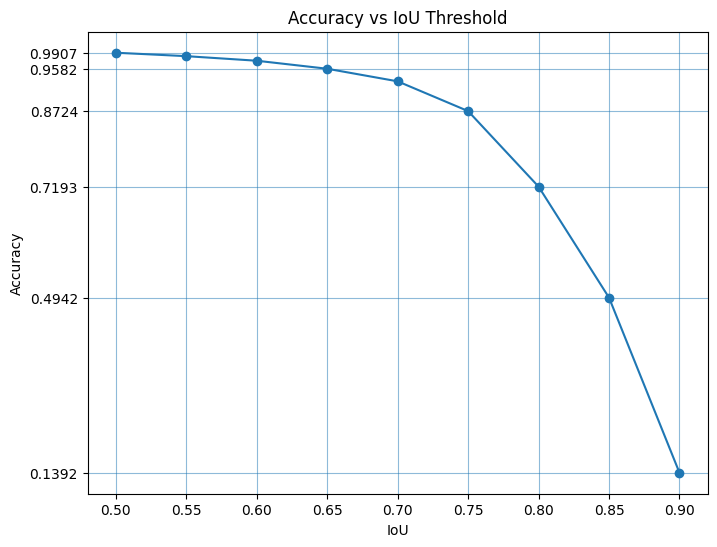

In [11]:
# Plotting the PR values over different threshold of the IoU
plt.figure(figsize=(8, 6))
plt.plot(iou_thresholds[:-1], accuracies[:-1], marker="o", label="Accuracy")
plt.xlabel("IoU")
plt.ylabel("Accuracy")
plt.title("Accuracy vs IoU Threshold")
plt.xticks(iou_thresholds[:-1])
plt.yticks(select_ticks(accuracies[:-1], sorting='descending', threshold=0.03))
plt.grid(color='tab:blue', alpha=0.5)
plt.show()

Loss-mIoU Plot

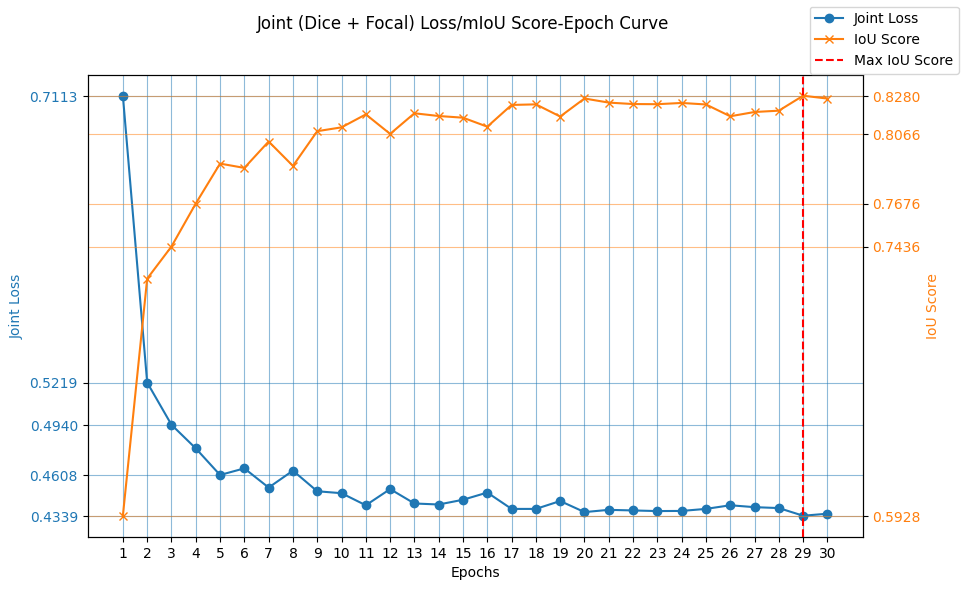

In [12]:
import pandas as pd

df = pd.read_csv(r'models\U-Net(scse)_mit-b2(frozen)_imagenet\test_logs.csv')

joint_loss = df['joint_loss']
iou_score = df['iou_score']

fig, ax1 = plt.subplots(figsize=(10, 6))
epochs = range(1, len(joint_loss) + 1)

ax1.plot(epochs, joint_loss, label='Joint Loss', marker='o', color='tab:blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Joint Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(epochs)
ax1.set_yticks(select_ticks(joint_loss, sorting='ascending'))

ax2 = ax1.twinx()
ax2.plot(epochs, iou_score, label='IoU Score', marker='x', color='tab:orange')
ax2.set_ylabel('IoU Score', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_yticks(select_ticks(iou_score, sorting='descending'))
best_idx = iou_score.idxmax()
ax2.axvline(x=best_idx + 1, color='red', linestyle='--', label='Max IoU Score')

fig.suptitle('Joint (Dice + Focal) Loss/mIoU Score-Epoch Curve')
fig.legend(loc='upper right')
ax1.grid(visible=True, color='tab:blue', linestyle='-', alpha=0.5)
ax2.grid(visible=True, color='tab:orange', linestyle='-', alpha=0.5)
plt.show()


Pixel-level Precision-Recall-F1 Plot

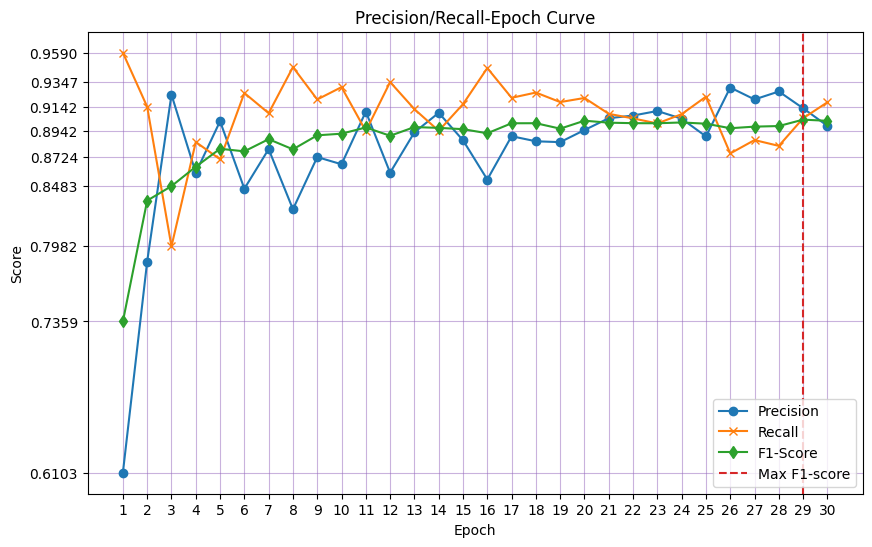

In [17]:
df = pd.read_csv(r'models\U-Net(scse)_mit-b2(frozen)_imagenet\test_logs.csv')

precision = df['precision']
recall = df['recall']
fscore = df['fscore']
epochs = range(1, len(precision) + 1)

plt.rcParams["figure.figsize"] = (10, 6)

plt.plot(epochs, precision, label='Precision', marker='o', color='tab:blue')
plt.plot(epochs, recall, label='Recall', marker='x', color='tab:orange')
plt.plot(epochs, fscore, label='F1-Score', marker='d', color='tab:green')
best_idx = fscore.idxmax()
plt.axvline(x=best_idx + 1, color='tab:red', linestyle='--', label='Max F1-score')

plt.title('Precision/Recall-Epoch Curve')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.xticks(epochs)
plt.yticks(select_ticks(pd.concat([precision, recall, fscore])))
plt.grid(visible=True, color='tab:purple', linestyle='-', alpha=0.5)
plt.show()


## Visualize predictions

In [14]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
)

In [15]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show()

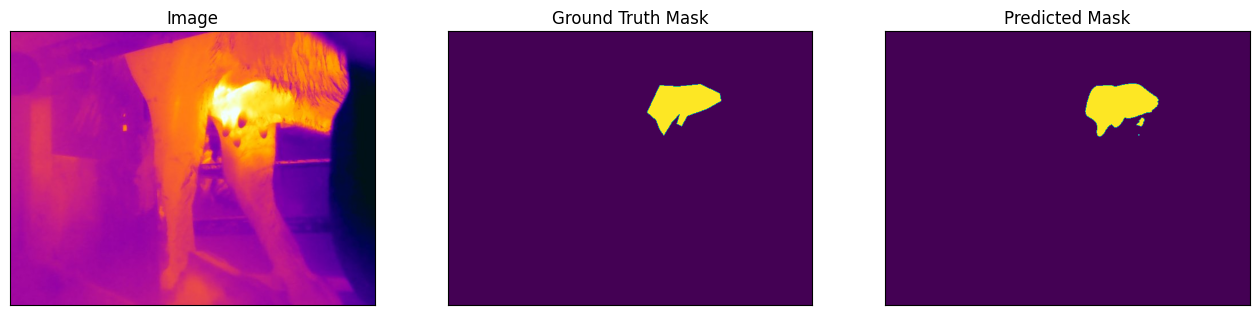

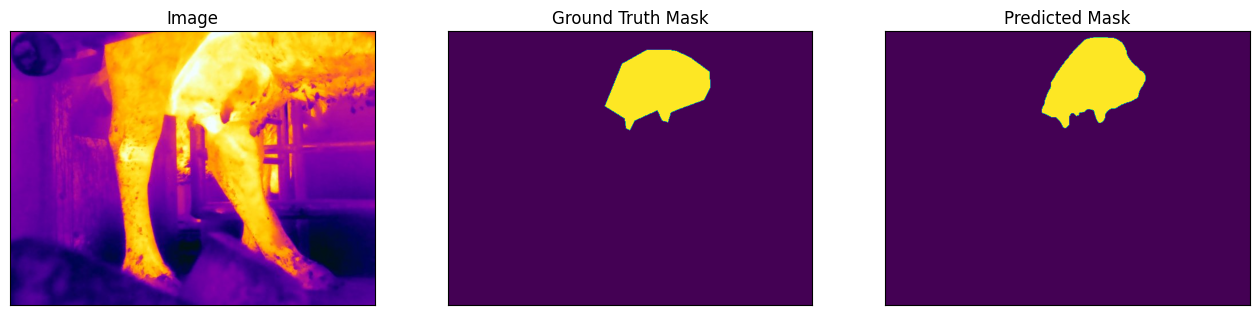

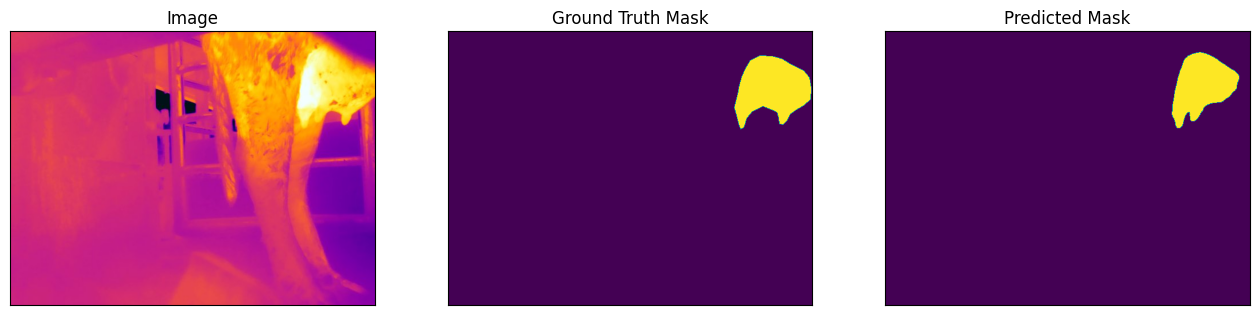

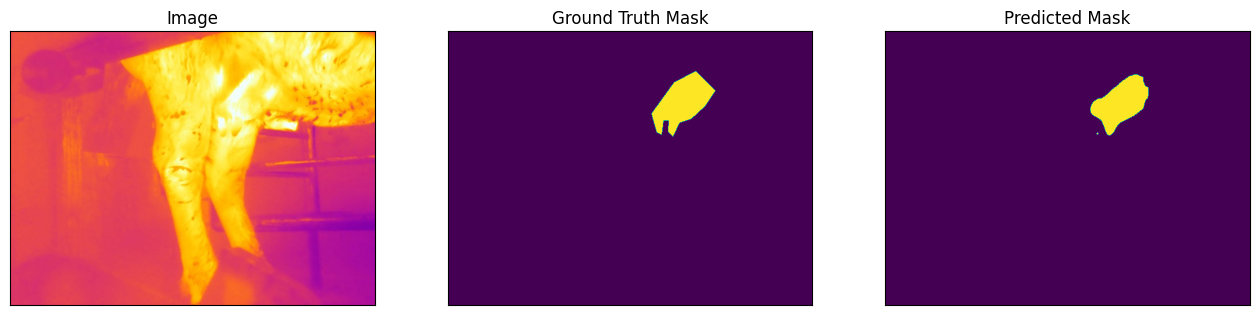

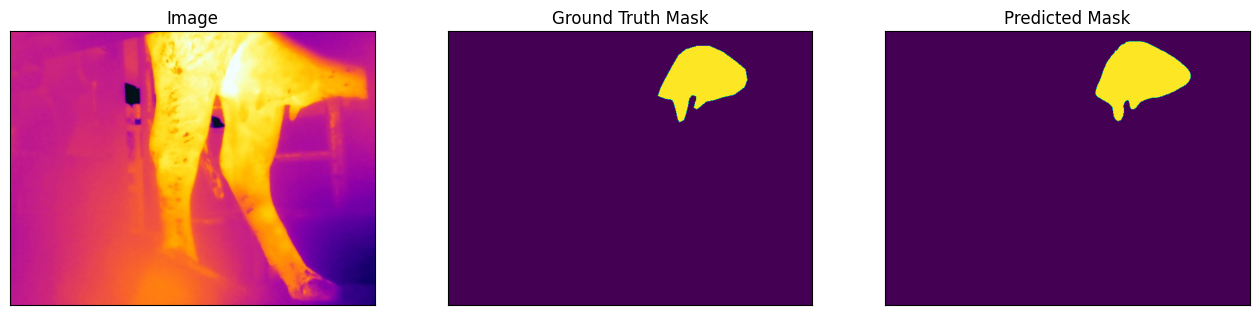

In [16]:
for i in range(5):
    n = np.random.choice(len(test_dataset))

    image_vis = test_dataset_vis[n][0].astype("uint8")
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()

    visualize(image=image_vis, ground_truth_mask=gt_mask, predicted_mask=pr_mask)